# Deep Flow Prediction
Based on:
<br>
 https://arxiv.org/abs/1810.08217 by N. Thuerey, K. Weissenov, H. Mehrotra, N. Mainali, L. Prantl, X. Hu (TUM)
<br>
https://github.com/thunil/Deep-Flow-Prediction

## Aim:
Predicting approximate solutions to Reynolds-Averaged Navier-Stokes equation with best possible accuracy by application of a deep neural network

In [3]:
# First the model is initialized and pre-trained weights are loaded
import matplotlib.pyplot as plt
from matplotlib.pyplot import quiver
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import tensorflow.compat.v1 as tf
from tensorflow.python.platform import gfile

from dataset import TurbDataset
from DfpNet import build_graph
import utils




test_path = "../data/test/"
dataset = TurbDataset(None, mode=TurbDataset.TEST, dataDirTest=test_path)

model = build_graph() # a frozen tensorflow graph representation of the pytorch model 

loading data for testing
Number of data loaded: 90
Using fixed maxima [4.65, 2.04, 2.37]
Data stats, input  mean 0.190220, max  0.961052;   targets mean 0.289502 , max 1.000000 
--------------------------------------------------
Frozen model layers: 
number of layers 877


![title](../resources/overview.jpg)

# Summary of approach:
### Input:
3-channel image corresponding to the freestream conditions (i.e. the distant velocity field which can be assumed to be uneffected by the airfoil) and the shape of the airfoil as mask (1 inside and 0 outside of the airfoil)
### Output:
The predicted velocity vector field (2-channels) around the airfoil as well as the scalar pressure field (1-channel)
### Model: 
The Model is based on a U-net architecture which is actually the standard architecture for segmentation problems. The prediction happens by a basically symmetric process of downsampling (==> increase of global information resp. feature extraction but loss of local information) followed by a corresponding upsampling where related layer outputs of the down- and upsampling steps are resp. concatenated for further processing (==> regaining local information/resolution using the global and local features at the same time) 
<br>
**Layer blocks for downsampling**:
Convolutional layers with stride 2 (needed for downsampling) and kernel size 4 followed by LeakyRelu activation
<br>
**Layer blocks for upampling:**
Simple Upsampling layer (factor 2) followed by Convolutions with stride 1 and kernel size 3 as well as Relu activation
<br>
In both cases batchnorm is used.
<br>
**Heursitic justification for the approach:**
<br>
PDEs are problems of finding global functions given local information about them (resp. information about the function's partial derivatives) and boundary conditions. Thus, the process of aggregating local information in several steps considering the airfoil shape and the freefield followed by a sequential creation of the solution (using both aggregated and local information) seems to be a reasonable approach.

In [24]:
# functions for evaluation

def get_rel_MAE(y_true,y_pred,channels=[0,1,2],absolute=False):
    """Function takes output and target array and returns their MAE divided by the average target_value.

    Args:
        y_true (np.array): array with ground truth information
        y_pred (np.array): prediction of model
        channels (list): list containing indices (in [0,1,2]) corrsponding to the channels which shall be considered for evaluation
    """
    if absolute:
        return np.abs(y_true[channels] - y_pred[channels]).mean()
    abs_MAE = np.abs(y_true[channels] - y_pred[channels]).sum()
    abs_tar = np.maximum(np.abs(y_true[channels]).sum(),1e-8)
    return abs_MAE/abs_tar
    

def evaluate_model(model,print_all_losses=False, device='cpu',path="../data/test/",torch=False):
    """Function evaluates model using 'unseen' input data. Model performance is measured regarding MAE normalized 
       by the average absolute value of target quantities.
       
    Args:
        model (tf2 model): pretrained tf2 model
        print_all_losses (bool): True if for each sample of the test data the respective losses shall be printed
        normalize (bool): the array will be normalized to range [0,1] before being plotted if True 
        device (str): 'cpu' or 'gpu'
        path (str): path to test data
        torch (bool): True if instead of the frozen tf graph a torch model is provided for inference
    """

    dataset = TurbDataset(None, mode=TurbDataset.TEST, dataDirTest=path)
    testLoader = DataLoader(dataset, batch_size=1, shuffle=False)

    avgLoss = 0.

    lossPer_p_accum = 0 # rel MAE for scaled pressure field
    lossPer_v_accum = 0 # rel MAE for scaled velocity field
    lossPer_accum = 0 # rel MAE for scaled data in total (resp. all channels)

    L1val_dn_accum = 0.0 # absolute MAE for unscaled data in total 
    
    if torch:
        model.eval()

    preds = []
    tars = []

    count = 0
    for i, data in enumerate(testLoader):
        # loading of test samples
        count += 1
        inputs_cpu, targets_cpu = data
        inputs = inputs_cpu.float()
        targets_cpu = targets_cpu.float().numpy()[0]

        # model prediction
        if torch:
            with torch.no_grad():
                inputs = inputs_cpu.to(device)
                outputs_cpu = model(inputs).cpu().numpy()[0]
        else:
            outputs_cpu = model(model_inputs=tf.constant(inputs.numpy()))[0].numpy()[0]


        lossL1 = get_rel_MAE(outputs_cpu, targets_cpu,absolute=True) # (absolute) MAE

        # precentage loss by ratio of means which is same as the ratio of the sum
        lossPer_p = get_rel_MAE(targets_cpu,outputs_cpu,[0]) # rel MAE for pressure
        lossPer_v = get_rel_MAE(targets_cpu,outputs_cpu,[1,2])  # rel MAE for velocity field
        lossPer = get_rel_MAE(targets_cpu,outputs_cpu) # rel MAE for all channels

        lossPer_p_accum += lossPer_p.item()
        lossPer_v_accum += lossPer_v.item()
        lossPer_accum += lossPer.item()

        if print_all_losses:
            print("Test sample %d" % i)
            print("relative L_1 error for pressure p:", lossPer_p)
            print("relative L_1 error for v_x:", get_rel_MAE(targets_cpu,outputs_cpu,[1]))
            print("relative L_1 error for v_x:", get_rel_MAE(targets_cpu,outputs_cpu,[2]))

        # Calculate the norm (necessary for unscaling the data)
        input_ndarray = inputs_cpu.cpu().numpy()[0]
        v_norm = (np.max(np.abs(input_ndarray[0, :, :])) ** 2 + np.max(np.abs(input_ndarray[1, :, :])) ** 2) ** 0.5

        outputs_denormalized_comp = dataset.denormalize(outputs_cpu, v_norm)
        targets_denormalized_comp = dataset.denormalize(targets_cpu, v_norm)

        # denormalized error (i.e. the error for the unscaled data)  
        lossL1_dn = get_rel_MAE(outputs_denormalized_comp,targets_denormalized_comp,absolute=True) 
        L1val_dn_accum += lossL1_dn.item()

    lossPer_p_accum /= count
    lossPer_v_accum /= count
    lossPer_accum /= count
    L1val_dn_accum /= count

    print(f"Loss percentage (p, v, combined) for scaled data: ({np.round(lossPer_p_accum * 100,3)}%, {np.round(lossPer_v_accum * 100,4)}%, {np.round(lossPer_accum * 100,4)}%)")

    print(f"absolute denormalized error: {np.round(L1val_dn_accum,5)}")

In [25]:
evaluate_model(model,print_all_losses=False, device='cpu',path="../data/test/")

loading data for testing
Number of data loaded: 90
Using fixed maxima [4.65, 2.04, 2.37]
Data stats, input  mean 0.190220, max  0.961052;   targets mean 0.289502 , max 1.000000 
Loss percentage (p, v, combined) for scaled data: (13.048%, 1.9175%, 2.3167%)
absolute denormalized error: 0.01029


In [36]:
# functions for visualization

def imageOut(_outputs, _targets,inputs,normalize=False):
    """Function takes output and target array and returns their corresponding images.

    Args:
        _outputs (np.array): prediction of model
        _targets (np.array): array with ground truth information
        normalize (bool): the array will be normalized to range [0,1] before being plotted if True 
    """
    outputs = np.copy(_outputs)
    targets = np.copy(_targets)
    
    print('direction of the freefield')
    quiver( inputs[0,0,0]*np.ones((10,10)), inputs[1,0,0]*np.ones((10,10)))
    plt.show()

    for i in range(3):
        outputs[i] = np.flipud(outputs[i].transpose())
        targets[i] = np.flipud(targets[i].transpose())
        min_value = min(np.min(outputs[i]), np.min(targets[i]))
        max_value = max(np.max(outputs[i]), np.max(targets[i]))

        if normalize:
            outputs[i] -= min_value
            targets[i] -= min_value
            max_value -= min_value
            outputs[i] /= max_value
            targets[i] /= max_value
        else:  # from -1,1 to 0,1
            outputs[i] -= -1.
            targets[i] -= -1.
            outputs[i] /= 2.
            targets[i] /= 2.
    
    for n,c in {'pressure':0,'v_x':1,'v_y':2}.items():
        if normalize and n!='pressure':
            print(f'Image of {n} prediction (left) vs. Image of {n} target (right) resp. normalized to [0,1]:') 
        else:
            print(f'Image of {n} prediction (left) vs. Image of {n} target (right):')   
        fig, axarr = plt.subplots(1,2,figsize=(10,10))
        axarr[0].imshow(outputs[c])
        im = axarr[1].imshow(targets[c])
        
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.345, 0.04, 0.31])
        fig.colorbar(im, cax=cbar_ax)
        
        plt.show()
        

Test sample 20
relative L_1 error for p: 3.860028098006016%
relative L_1 error for v_x: 0.237390964957068%
relative L_1 error for v_y: 2.647286731828784%
--------------------------
direction of the freefield


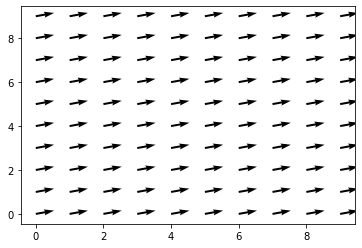

Image of pressure prediction (left) vs. Image of pressure target (right):


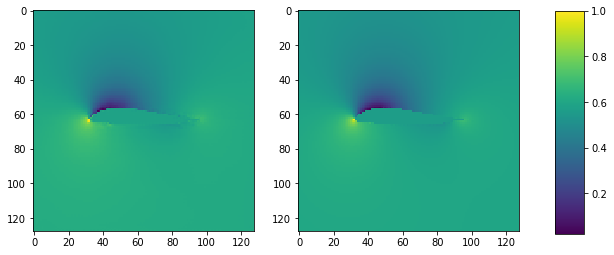

Image of v_x prediction (left) vs. Image of v_x target (right) resp. normalized to [0,1]:


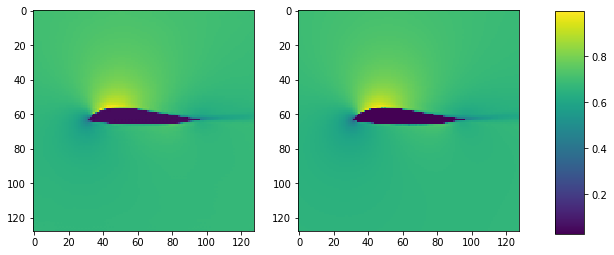

Image of v_y prediction (left) vs. Image of v_y target (right) resp. normalized to [0,1]:


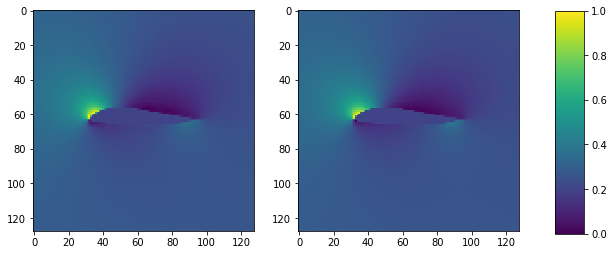

In [39]:
# Example of a workflow for the detailed evaluation of individual model predictions

i = 20 # insert index of test sample which shall be analyzed 
i = i%len(dataset)

inputs, targets = dataset.__getitem__(i)

# model prediction
outputs = model(model_inputs=tf.constant(inputs[None,...].astype('float32')))[0].numpy()[0]

print("Test sample %d" % i)
print(f"relative L_1 error for p: {get_rel_MAE(outputs,targets,0)*100}%")
print(f"relative L_1 error for v_x: {get_rel_MAE(outputs,targets,1)*100}%")
print(f"relative L_1 error for v_y: {get_rel_MAE(outputs,targets,2)*100}%")
print("--------------------------")

imageOut(outputs,targets,inputs,normalize=True)
